# Machine Learning Price Movement Trading Strategy

In [1]:
# Import libraries
import math  
import pandas_datareader as web  
import yfinance as yf  
import datetime  
import numpy as np  
import pandas as pd 
import scipy.stats as stats 
import matplotlib.dates as mdates
import matplotlib.pyplot as plt 
import random
from sklearn.preprocessing import MinMaxScaler  
from keras.models import Sequential  
from keras.layers import Dense, LSTM  
from sklearn.model_selection import TimeSeriesSplit

## Get data for S&P500 via Yahoo API and simulate random walk

In [2]:
# Disable the SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Define the date range for data retrieval
start_date = datetime.datetime(2003, 1, 1)
end_date = datetime.datetime(2023, 1, 1)

# Fetch S&P500 data using Yahoo Finance
sp500 = yf.Ticker('^GSPC')
sp500_data = sp500.history(period="1d", start=start_date, end=end_date)

# Remove the time zone information from the date index
sp500_data.index = sp500_data.index.date

# Remove the specified columns and reorder the remaining ones
df = sp500_data[['High', 'Low', 'Open', 'Close', 'Volume']]

# Add a random walk column
random_walk = [909.030029,908.590027]
for _ in range(2, len(df)):
    close_t_minus_1 = df['Close'].iloc[_ - 1]
    close_t_minus_2 = df['Close'].iloc[_ - 2]
    e = close_t_minus_1 - close_t_minus_2  # Change e to be the difference between close_t-1 and close_t-2
    random_walk.append(close_t_minus_1 + e)

df['Random_Walk'] = random_walk
df['Date'] = df.index

# Display the DataFrame
df

,High,Low,Open,Close,Volume,Random_Walk,Date
2003-01-02,909.030029,879.820007,879.820007,909.030029,1229200000,909.030029,2003-01-02
2003-01-03,911.250000,903.070007,909.030029,908.590027,1130800000,908.590027,2003-01-03
2003-01-06,931.770020,908.590027,908.590027,929.010010,1435900000,908.150024,2003-01-06
2003-01-07,930.809998,919.929993,929.010010,922.929993,1545200000,949.429993,2003-01-07
2003-01-08,922.929993,908.320007,922.929993,909.929993,1467600000,916.849976,2003-01-08
...,...,...,...,...,...,...,...
2022-12-23,3845.800049,3797.010010,3815.110107,3844.820068,2819280000,3766.339844,2022-12-23
2022-12-27,3846.649902,3813.219971,3843.340088,3829.250000,3030300000,3867.250244,2022-12-27
2022-12-28,3848.320068,3780.780029,3829.560059,3783.219971,3083520000,3813.679932,2022-12-28
2022-12-29,3858.189941,3805.449951,3805.449951,3849.280029,3003680000,3737.189941,2022-12-29


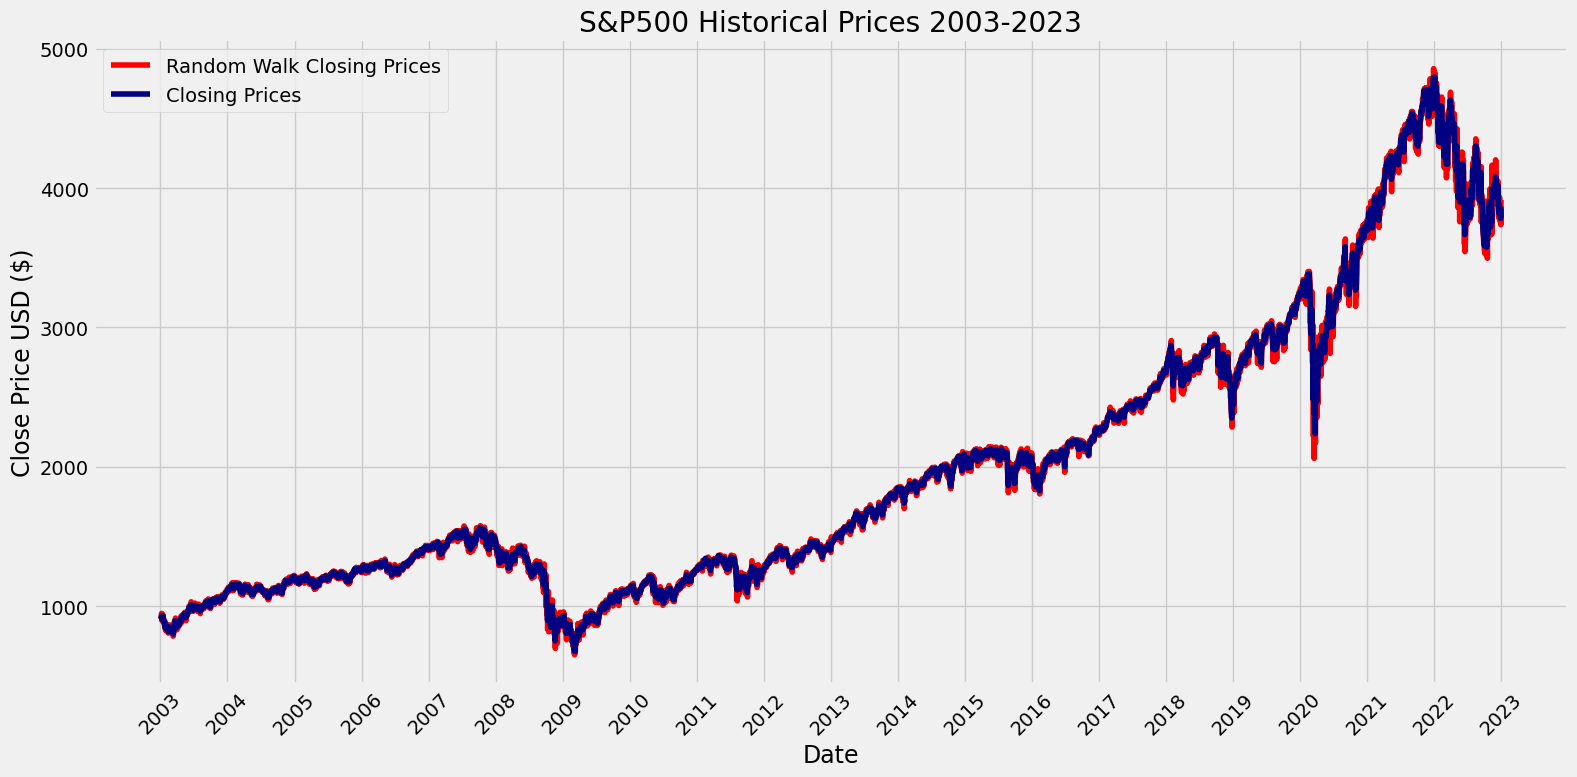

In [3]:
# Style the plots
plt.style.use('fivethirtyeight')

# Create a figure for the plot
plt.figure(figsize=(16, 8))

# Set the title for the plot
plt.title('S&P500 Historical Prices 2003-2023')

# Remove the first two rows from the DataFrame
df_without_two_rows = df.iloc[2:]

# Plot the closing prices over time and add labels
plt.plot(df_without_two_rows['Random_Walk'], color='red', label='Random Walk Closing Prices')
plt.plot(df['Close'], color='navy', label='Closing Prices')

# Label the x-axis and y-axis
plt.xlabel('Date', fontsize=17)
plt.ylabel('Close Price USD ($)', fontsize=17)

# Add a legend to the plot
plt.legend()

# Configure the x-axis to show more dates and display only the years
ax = plt.gca()

# Use YearLocator to set the ticks at yearly intervals
years = mdates.YearLocator()

# Use DateFormatter to format the x-axis labels as years
year_format = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(year_format)

# Display the plot
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.tight_layout()  # Ensure all elements fit within the figure
plt.show()

## Build and train the LSTM model

In [4]:
# Create a new DataFrame with only the 'Close' column
data = df.filter(['Close'])

# Convert the DataFrame to a NumPy array
dataset = data.values

# Determine the number of rows for training the model (80% of the data)
training_data_len = math.ceil(len(dataset) * 0.8)

# Print the calculated training data length
print(training_data_len)

# Create a Min-Max scaler object with a specified feature range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the dataset and store it in a new variable
scaled_data = scaler.fit_transform(dataset)

# Print the scaled data
print(scaled_data)

# Create the training data set
train_data = scaled_data[0:training_data_len, :]

# Initialize empty lists for training data and labels
x_train = []  # Input sequences
y_train = []  # Corresponding output values

# Iterate through the data to create training sequences
for i in range(60, len(train_data)):
    # Create input sequence with the previous 60 data points
    x_train.append(train_data[i-60:i, 0])
    
    # Create the corresponding output value
    y_train.append(train_data[i, 0])

    # Print the input sequences and labels for the first iteration
    if i <= 60:
        print(x_train)
        print(y_train)
        print()

4028
[[0.05643163]
 [0.05632483]
 [0.0612811 ]
 ...
 [0.75404546]
 [0.77007934]
 [0.76770556]]
[array([0.05643163, 0.05632483, 0.0612811 , 0.05980538, 0.05665006,
       0.06093159, 0.06093159, 0.06061363, 0.06192429, 0.05866218,
       0.05778355, 0.05467193, 0.05123506, 0.0489875 , 0.0511671 ,
       0.04487103, 0.0414924 , 0.04417685, 0.04558946, 0.04079581,
       0.04348754, 0.04460889, 0.04166717, 0.04054825, 0.03922787,
       0.03717448, 0.03869873, 0.03705555, 0.03450217, 0.03418421,
       0.03843661, 0.04238803, 0.04092203, 0.038973  , 0.04165988,
       0.03787593, 0.03932981, 0.03665506, 0.03901671, 0.03995602,
       0.03841719, 0.03530556, 0.03721331, 0.03533225, 0.03698031,
       0.03178374, 0.0301454 , 0.0309852 , 0.03771089, 0.03804341,
       0.0452084 , 0.04609675, 0.04793411, 0.04833459, 0.05321805,
       0.04555791, 0.04810886, 0.04694626, 0.04659917, 0.04538073])]
[0.04166230880802588]



In [5]:
# Convert the x_train and y_train lists to NumPy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the training data to match the input requirements of an LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Print the shape of the reshaped training data
x_train.shape

(3968, 60, 1)

# Create an LSTM model
model = Sequential()

# Add the first LSTM layer with 50 units and return sequences
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Add the second LSTM layer with 50 units and do not return sequences
model.add(LSTM(50, return_sequences=False))

# Add a dense layer with 25 units
model.add(Dense(25))

# Add the output layer with a single unit for regression
model.add(Dense(1))

# Compile the LSTM model (Adaptive Moment Estimation)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model with the training data
model.fit(x_train, y_train, batch_size=1, epochs=2)

In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Split your data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Define a function to build the LSTM model with hyperparameters as arguments
def build_lstm_model(hp):
    model = Sequential()
    units = hp.Int('units', min_value=32, max_value=256, step=32)
    dense_units = hp.Int('dense_units', min_value=16, max_value=128, step=16)
    optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
    loss = hp.Choice('loss', values=['mse', 'mae'])

    model.add(LSTM(units=units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dense(units=dense_units))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss)
    return model

# Initialize a tuner
tuner = RandomSearch(build_lstm_model, objective='val_loss', max_trials=10, directory='my_dir', project_name='my_project')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Perform the hyperparameter search
tuner.search(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[early_stopping])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the final model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

# Compile and train the final model with a large number of epochs (early stopping will determine the actual number)
final_model.compile(optimizer=best_hps.get('optimizer'), loss=best_hps.get('loss'))
final_model.fit(x_train, y_train, batch_size=1, epochs=100)

Using TensorFlow backend

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
224               |224               |units
64                |64                |dense_units
adam              |adam              |optimizer
mae               |mae               |loss

Epoch 1/100
100/100 [==============================] - 13s 122ms/step - loss: 0.0198 - val_loss: 0.0088
Epoch 2/100
100/100 [==============================] - 12s 123ms/step - loss: 0.0076 - val_loss: 0.0049
Epoch 3/100
100/100 [==============================] - 12s 121ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 4/100
100/100 [==============================] - 12s 122ms/step - loss: 0.0070 - val_loss: 0.0111
Epoch 5/100
100/100 [==============================] - 12s 123ms/step - loss: 0.0066 - val_loss: 0.0086
Epoch 6/100
100/100 [==============================] - 12s 123ms/step - loss: 0.0055 - val_loss: 0.0079
Epoch 7/100
100/100 [==============================] - 12s 124ms/step - loss: 0.0055 

KeyboardInterrupt: 

## Test the LSTM model and make predictions

In [9]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]

# Initialize empty lists for testing data and labels
x_test = []  # Input sequences
y_test = dataset[training_data_len:, :]  # Corresponding output values

# Iterate through the test data to create testing sequences
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [10]:
# Convert the testing input data to a NumPy array
x_test = np.array(x_test)

# Reshape the testing input data to match the input requirements of the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values for the test data
predictions = model.predict(x_test)

# Inverse transform the scaled predictions to their original scale
predictions = scaler.inverse_transform(predictions)

32/32 [==============================] - 0s 5ms/step


In [11]:
# Check the shape of the array
print(predictions.shape)

# Calculate the Root Mean Squared Error (RMSE)for the strategy
rmse_strategy = np.sqrt(np.mean((predictions - y_test)**2))
rmse_strategy

(1007, 1)


63.723443377587195

In [12]:
# Extract random walk values
df['Date'] = pd.to_datetime(df['Date'])
df_random = df[df['Date'] >= '2019-01-03']

random_predictions = df_random['Random_Walk']

# Make random walk values into an array
random_predictions = np.array(random_predictions)

# Reshape data1 to have shape (503, 1)
random_predictions_reshaped = random_predictions.reshape(-1, 1)

# Check the shape of the reshaped array
print(random_predictions_reshaped.shape)

# Calculate the Root Mean Squared Error (RMSE)for the random walk
random_predictions_reshaped = np.sqrt(np.mean((random_predictions_reshaped - y_test)**2))
random_predictions_reshaped

(1007, 1)


72.34948039516128

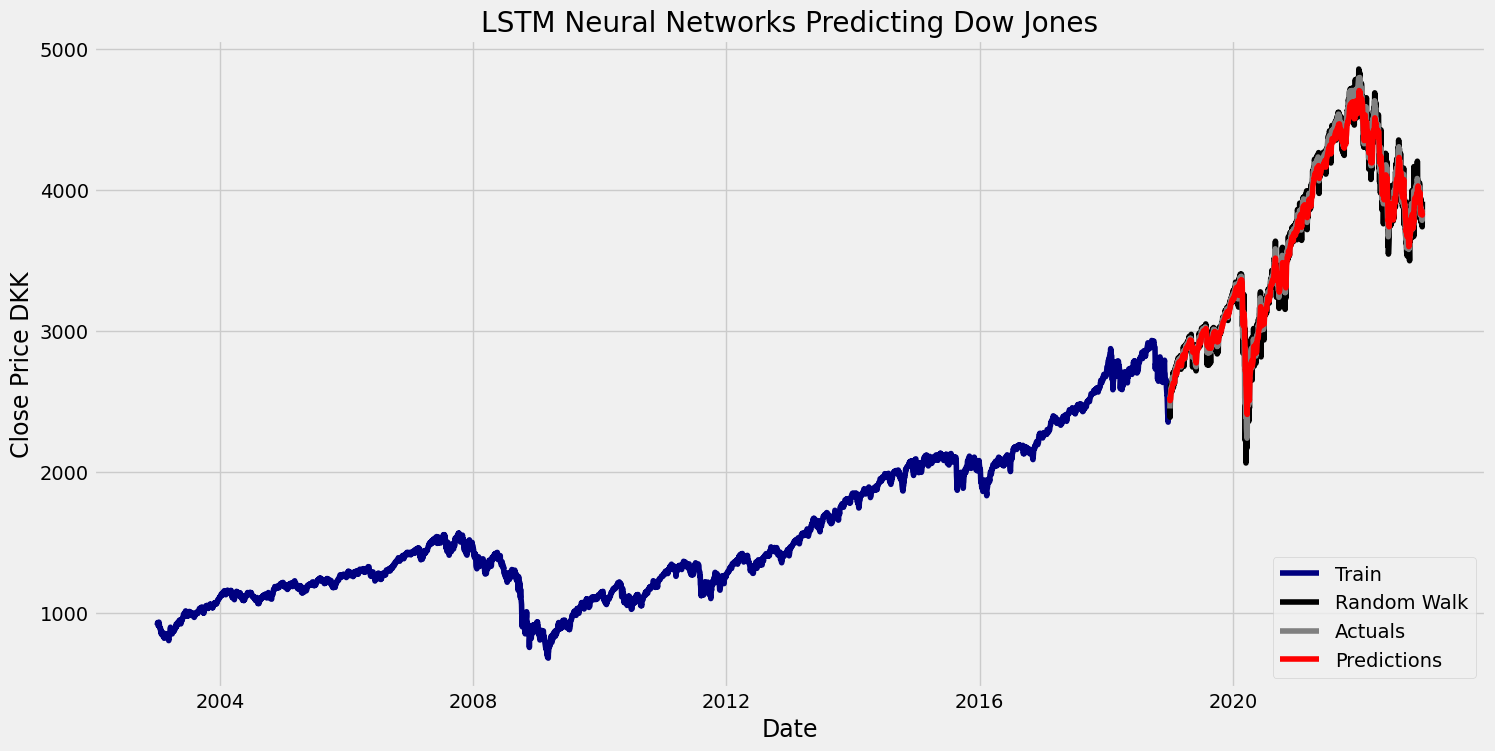

In [13]:
# Separate the data into training and validation sets
train = data[:training_data_len]
valid = data[training_data_len:]
valid = valid.copy()  # Create a copy to avoid the SettingWithCopyWarning
valid['Predictions'] = predictions  # Add predicted values to the 'valid' DataFrame

# Create a plot to visualize the data
plt.figure(figsize=(16, 8))
plt.title('LSTM Neural Networks Predicting Dow Jones')
plt.xlabel('Date', fontsize=17)
plt.ylabel('Close Price DKK', fontsize=17)

# Plot the 'Close' prices from the training data
plt.plot(train['Close'], label='Train', color='navy')

# Add the entire random walk to the plot
plt.plot(df_random['Random_Walk'], label='Random Walk', color='black')

# Plot the 'Close' prices from the validation data
plt.plot(valid['Close'], label='Actuals', color='grey')

# Plot the 'Predictions' from the validation data
plt.plot(valid['Predictions'], label='Predictions', color='red')

# Add a legend to the plot
plt.legend(loc='lower right')

# Display the plot
plt.show()

## Time series split cross validation

In [14]:
# Define the number of splits
n_splits = 5 

# Create a new DataFrame with only the 'Close' column
data = df.filter(['Close'])

# Convert the DataFrame to a NumPy array
dataset = data.values

# Create a Min-Max scaler object with a specified feature range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the dataset and store it in a new variable
scaled_data = scaler.fit_transform(dataset)

# Initialize the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lists to store RMSE values for each fold
rmse_values = []

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Iterate through the time series splits
for train_index, test_index in tscv.split(scaled_data):
    # Split the data into training and testing sets for this fold
    train_data, test_data = scaled_data[train_index], scaled_data[test_index]

    # Create the training data set
    x_train, y_train = [], []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i - 60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Create the testing data set
    x_test, y_test = [], []

    for i in range(60, len(test_data)):
        x_test.append(test_data[i - 60:i, 0])

    x_test, y_test = np.array(x_test), test_data[60:, 0]

    # Get the model's predicted price values for the test data
    predictions = model.predict(x_test)

    # Inverse transform the scaled predictions to their original scale
    predictions = scaler.inverse_transform(predictions)

    # Calculate the Root Mean Squared Error (RMSE) for this fold
    rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
    rmse_values.append(rmse)

# Calculate the average RMSE across all folds
average_rmse = np.mean(rmse_values)
print("Average RMSE:", average_rmse)

25/25 [==============================] - 0s 5ms/step
Average RMSE: 694.7177192853165


## Comparing the actual stock movement with random walk and predictions

In [15]:
# Calculate the daily percentage change in the actual close prices
valid['Actual_Pct_Change'] = valid['Close'].pct_change() * 100

# Create a new column 'Buy_Sell' based on the prediction strategy
valid['Buy_Sell'] = valid['Predictions'].shift(-1) > valid['Close']

# Create a new column 'Buy_Sell_random' based on the random walk 
valid['Buy_Sell_random'] = df_random['Random_Walk'].shift(-1) > valid['Close']

# Calculate the daily percentage gain based on the strategy
valid['Strategy_Pct_Change'] = valid['Buy_Sell'].shift(1) * valid['Actual_Pct_Change']

# Calculate the daily percentage gain based on the random walk
valid['Strategy_Pct_Change_random'] = valid['Buy_Sell_random'].shift(1) * valid['Actual_Pct_Change']

# Calculate the cumulative percentage gain for the strategy
valid['Cumulative_Strategy_Gain'] = (1 + valid['Strategy_Pct_Change'] / 100).cumprod() - 1

# Calculate the cumulative percentage gain for the random walk
valid['Cumulative_Random_Gain'] = (1 + valid['Strategy_Pct_Change_random'] / 100).cumprod() - 1

# Calculate the cumulative percentage gain if holding the entire period
valid['Cumulative_Hold_Gain'] = (1 + valid['Actual_Pct_Change'] / 100).cumprod() - 1

# Print the last row of the DataFrame to get the final cumulative gains
final_cumulative_strategy_gain = valid['Cumulative_Strategy_Gain'].iloc[-1]
final_cumulative_hold_gain = valid['Cumulative_Hold_Gain'].iloc[-1]
final_cumulative_random_gain = valid['Cumulative_Random_Gain'].iloc[-1]

print(f'Cumulative Percentage Gain with Strategy: {final_cumulative_strategy_gain:.2%}')
print(f'Cumulative Percentage Gain with Holding: {final_cumulative_hold_gain:.2%}')
print(f'Cumulative Percentage Gain with Random Walk: {final_cumulative_random_gain:.2%}')

Cumulative Percentage Gain with Strategy: 25.34%
Cumulative Percentage Gain with Holding: 56.85%
Cumulative Percentage Gain with Random Walk: -8.04%


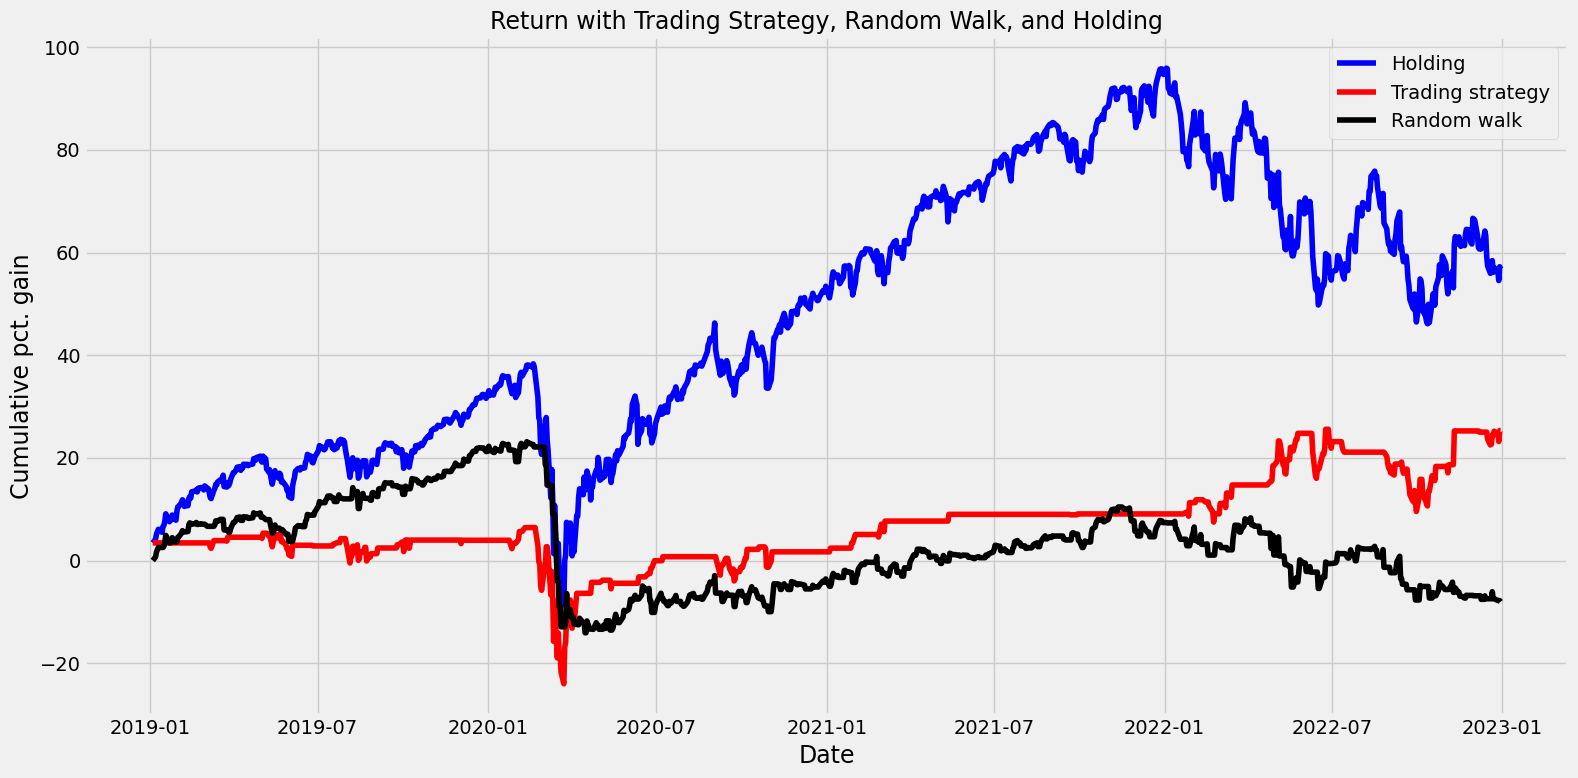

In [16]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the cumulative percentage gain for the actual stock price
ax.plot(valid.index, valid['Cumulative_Hold_Gain'] * 100, label='Holding', color='blue')

# Plot the cumulative percentage gain with predictions
ax.plot(valid.index, valid['Cumulative_Strategy_Gain'] * 100, label='Trading strategy', color='red')

# Plot the cumulative percentage gain with predictions
ax.plot(valid.index, valid['Cumulative_Random_Gain'] * 100, label='Random walk', color='black')

# Set labels and title
ax.set_xlabel('Date', fontsize=17)
ax.set_ylabel('Cumulative pct. gain', fontsize=17)
ax.set_title('Return with Trading Strategy, Random Walk, and Holding', fontsize=17)

# Add a legend
ax.legend()

# Add a grid
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [17]:
# Save the valid DataFrame to a CSV file
valid.to_csv('prediction_results_S&P500.csv', index=True)

In [18]:
# Skip the first row (header) and reset the index
valid = valid[1:].reset_index(drop=True)

# Calculate the number of correct and incorrect predictions
correct_predictions = ((valid['Actual_Pct_Change'] > 0) & (valid['Strategy_Pct_Change'] > 0)) | ((valid['Actual_Pct_Change'] < 0) & (valid['Strategy_Pct_Change'] == 0))
incorrect_predictions = ~correct_predictions

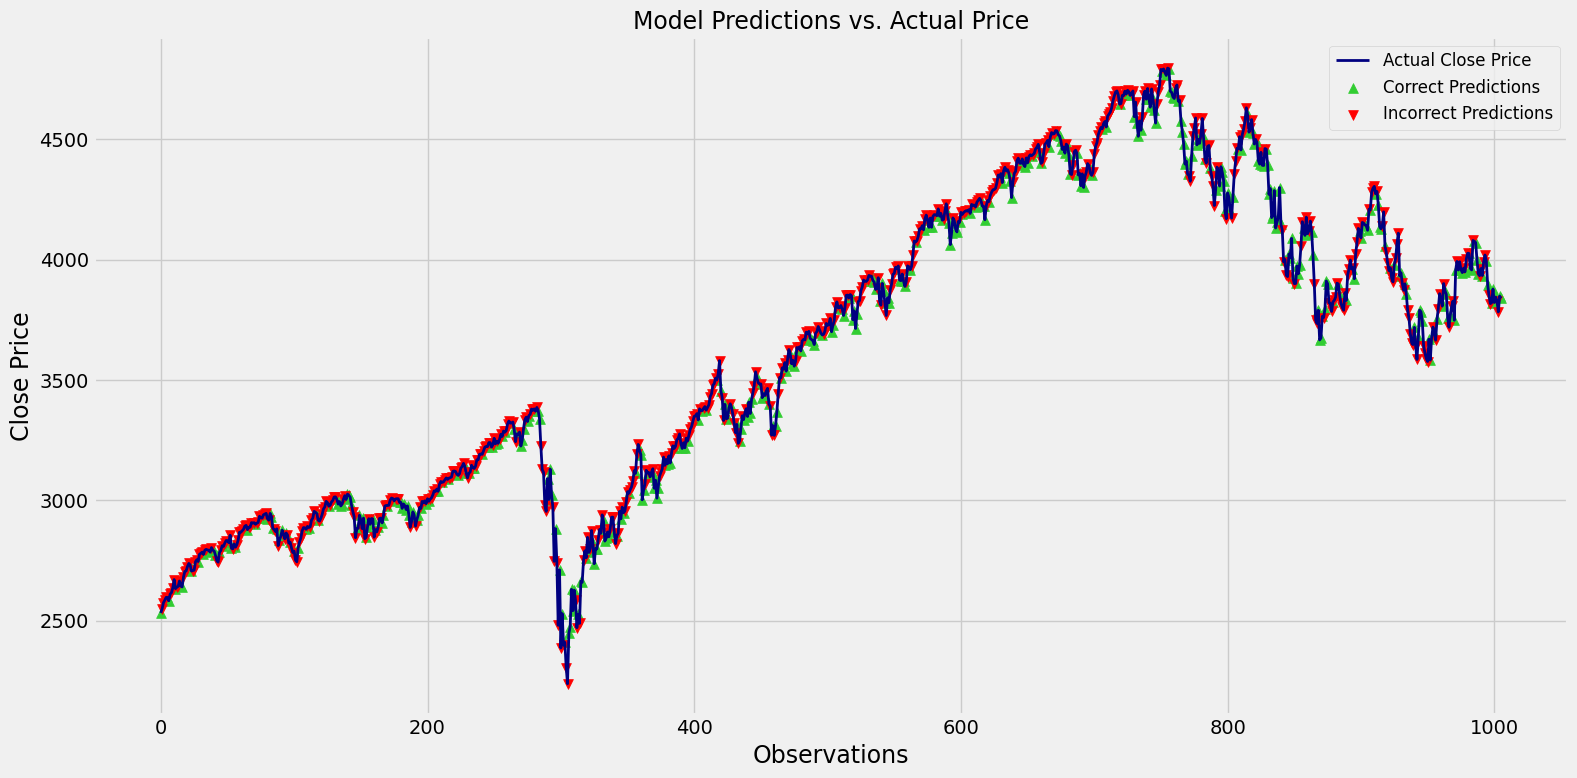

In [19]:
# Create a new column to represent correct and incorrect predictions
valid['Prediction_Type'] = 'Correct'
valid.loc[~correct_predictions, 'Prediction_Type'] = 'Incorrect'

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the actual close price
ax.plot(valid.index, valid['Close'], label='Actual Close Price', color='navy', linewidth=2)

# Plot correct predictions with green triangles (^)
ax.scatter(valid[valid['Prediction_Type'] == 'Correct'].index, valid[valid['Prediction_Type'] == 'Correct']['Close'],
            label='Correct Predictions', color='limegreen', marker='^', s=50)

# Plot incorrect predictions with red inverted triangles (v)
ax.scatter(valid[valid['Prediction_Type'] == 'Incorrect'].index, valid[valid['Prediction_Type'] == 'Incorrect']['Close'],
            label='Incorrect Predictions', color='red', marker='v', s=50)

# Set labels and title
ax.set_xlabel('Observations', fontsize=17)
ax.set_ylabel('Close Price', fontsize=17)
ax.set_title('Model Predictions vs. Actual Price', fontsize=17)

# Add a legend
ax.legend(fontsize=12)

# Add a grid
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [20]:
# Calculate the number of correct predictions for all percentage changes
correct_predictions = (valid['Strategy_Pct_Change'] == valid['Actual_Pct_Change'])
num_correct_predictions = correct_predictions.sum()

# Calculate the total number of observations in the dataset
total_observations = len(valid)

# Calculate the number of incorrect predictions
num_incorrect_predictions = total_observations - num_correct_predictions

# Calculate the percentage of correct predictions for all percentage changes
percentage_correct = (num_correct_predictions / total_observations) * 100

print(f'Number of correct predictions for all percentage changes: {num_correct_predictions}')
print(f'Number of incorrect predictions for all percentage changes: {num_incorrect_predictions}')
print(f'Percentage of correct predictions for all percentage changes: {percentage_correct:.2f}%')

Number of correct predictions for all percentage changes: 220
Number of incorrect predictions for all percentage changes: 786
Percentage of correct predictions for all percentage changes: 21.87%


In [21]:
# Filter the DataFrame for Pct. Change > 1% or < -1%
filtered_data = valid[(valid['Actual_Pct_Change'] > 1 ) | (valid['Actual_Pct_Change'] < -1)]

# Calculate the number of correct predictions
correct_predictions = (filtered_data['Strategy_Pct_Change'] == filtered_data['Actual_Pct_Change'])
num_correct_predictions = correct_predictions.sum()

# Calculate the total number of observations in the filtered data
total_observations = len(filtered_data)

# Calculate the number of incorrect predictions
num_incorrect_predictions = total_observations - num_correct_predictions

# Calculate the percentage of correct predictions
percentage_correct = (num_correct_predictions / total_observations) * 100

print(f'Number of correct predictions for Pct. Change > 1% or < -1%: {num_correct_predictions}')
print(f'Number of incorrect predictions for Pct. Change > 1% or < -1%: {num_incorrect_predictions}')
print(f'Percentage of correct predictions for Pct. Change > 1% or < -1%: {percentage_correct:.2f}%')

Number of correct predictions for Pct. Change > 1% or < -1%: 117
Number of incorrect predictions for Pct. Change > 1% or < -1%: 205
Percentage of correct predictions for Pct. Change > 1% or < -1%: 36.34%


In [22]:
# Create an empty list to store the results
results = []

# Generate percentage change values from 0 to 12 with an interval of 0.01
for pct_change in range(0, 1201): 
    pct_change /= 100
    
    # Filter the DataFrame for Pct. Change > 1% or < -1%
    filtered_data = valid[(valid['Actual_Pct_Change'] > pct_change) | (valid['Actual_Pct_Change'] < -pct_change)]

    # Calculate the number of correct predictions
    correct_predictions = (filtered_data['Strategy_Pct_Change'] == filtered_data['Actual_Pct_Change'])
    num_correct_predictions = correct_predictions.sum()

    # Calculate the total number of observations in the filtered data
    total_observations = len(filtered_data)

    # Check if total_observations is zero to avoid division by zero
    if total_observations == 0:
        percentage_correct = 0
    else:
        # Calculate the percentage of correct predictions
        percentage_correct = (num_correct_predictions / total_observations) * 100

    # Append the results as a dictionary to the 'results' list
    results.append({'Pct_Change': pct_change, 
                    'Num_Correct_Predictions': num_correct_predictions, 
                    'Num_Incorrect_Predictions': total_observations - num_correct_predictions, 
                    'Percentage_Correct': percentage_correct})

# Create a DataFrame from the list of dictionaries
results_df = pd.DataFrame(results)

# Filter rows where both 'Num_Correct_Predictions' and 'Num_Incorrect_Predictions' are not zero
results_df = results_df[(results_df['Num_Correct_Predictions'] != 0) | (results_df['Num_Incorrect_Predictions'] != 0)]

# Print or further analyze the 'results_df' DataFrame
results_df

,Pct_Change,Num_Correct_Predictions,Num_Incorrect_Predictions,Percentage_Correct
0,0.00,220,786,21.868787
1,0.01,220,778,22.044088
2,0.02,219,768,22.188450
3,0.03,219,762,22.324159
4,0.04,219,752,22.554068
...,...,...,...,...
1194,11.94,1,0,100.000000
1195,11.95,1,0,100.000000
1196,11.96,1,0,100.000000
1197,11.97,1,0,100.000000


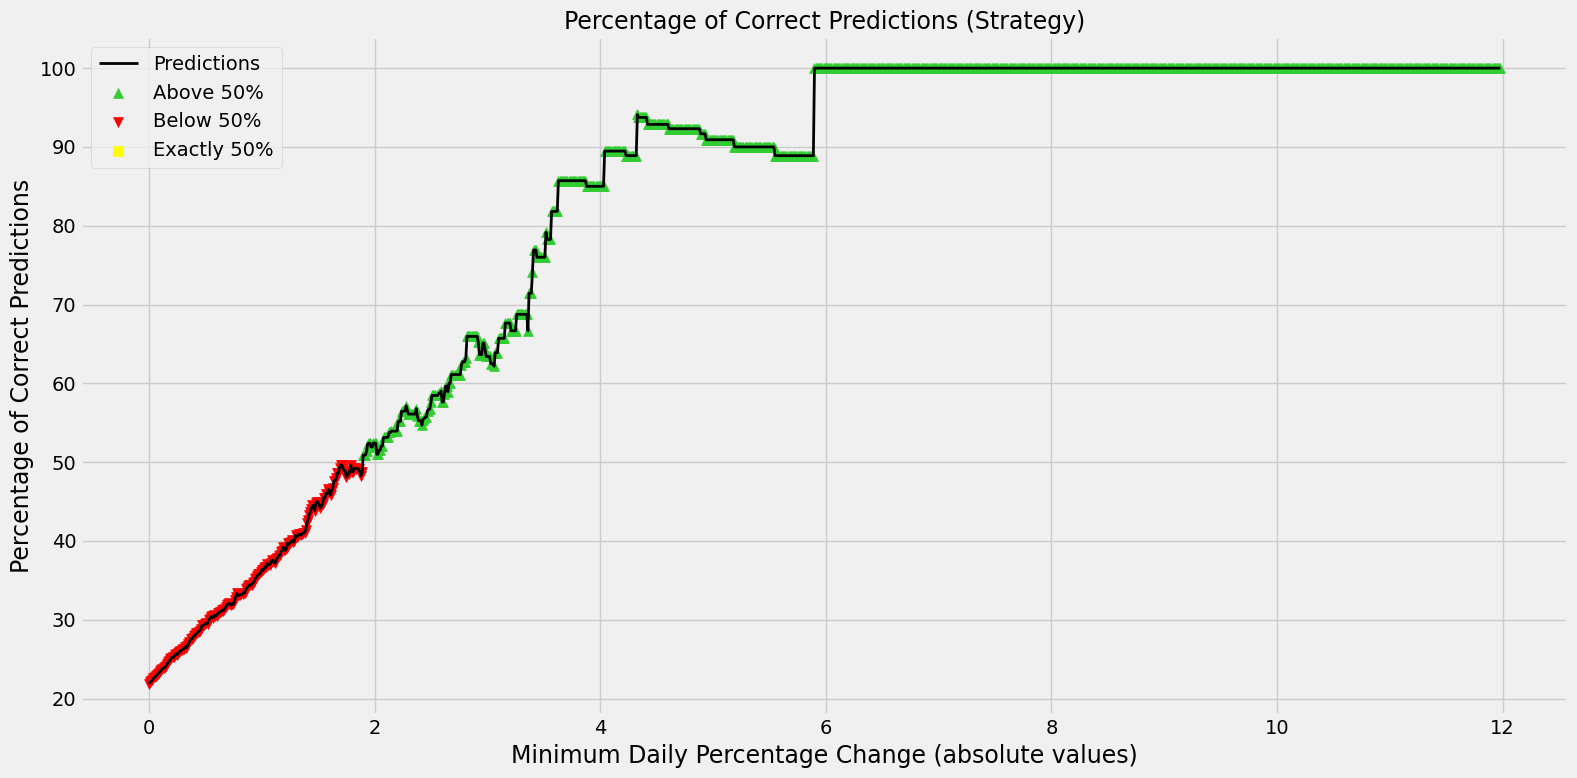

In [23]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Create a line plot connecting the points with linewidth 2
ax.plot(results_df['Pct_Change'], results_df['Percentage_Correct'], linestyle='-', color='black', linewidth=2, label='Predictions')

# Create a scatter plot with custom marker style for values above 50 on the y-axis
above_50_df = results_df[results_df['Percentage_Correct'] > 50]
ax.scatter(above_50_df['Pct_Change'], above_50_df['Percentage_Correct'], color='limegreen', marker='^', s=50, label='Above 50%',)

# Create a scatter plot with red markers for values below 50 on the y-axis
below_50_df = results_df[results_df['Percentage_Correct'] < 50]
ax.scatter(below_50_df['Pct_Change'], below_50_df['Percentage_Correct'], color='red', marker='v', s=50, label='Below 50%',)

# Create a scatter plot with yellow markers for values equal to 50 on the y-axis
equal_to_50_df = results_df[results_df['Percentage_Correct'] == 50]
ax.scatter(equal_to_50_df['Pct_Change'], equal_to_50_df['Percentage_Correct'], color='yellow', marker='s', s=50, label='Exactly 50%',)

# Set labels and title
ax.set_xlabel('Minimum Daily Percentage Change (absolute values)', fontsize=17)
ax.set_ylabel('Percentage of Correct Predictions', fontsize=17)
ax.set_title('Percentage of Correct Predictions (Strategy)', fontsize=17)

# Add a legend
ax.legend()

# Add a grid
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [24]:
# Create a new DataFrame with the top 10 biggest percentage changes
valid['Correct_Prediction'] = ((valid['Actual_Pct_Change'] > 0) & (valid['Strategy_Pct_Change'] == valid['Actual_Pct_Change'])) | ((valid['Actual_Pct_Change'] < 0) & (valid['Strategy_Pct_Change'] == 0))
top_10_positive_changes = valid.nlargest(10, 'Actual_Pct_Change')  # Top 10 positive changes
top_10_negative_changes = valid.nsmallest(10, 'Actual_Pct_Change')  # Top 10 negative changes

# Combine and sort the top changes
top_10_changes = pd.concat([top_10_positive_changes, top_10_negative_changes])
top_10_changes['Actual_Pct_Change'] = top_10_changes['Actual_Pct_Change'].apply(lambda x: f"{x:.6f}")

# Sort the DataFrame by the absolute values of 'Actual_Pct_Change'
top_10_changes['Actual_Pct_Change'] = top_10_changes['Actual_Pct_Change'].astype(float)
top_10_changes = top_10_changes.iloc[top_10_changes['Actual_Pct_Change'].abs().argsort()[::-1]]

# Display the resulting DataFrame without the index, limited to the top 10 rows
result_df = top_10_changes[['Actual_Pct_Change', 'Correct_Prediction']]
result_df = result_df.head(20)
print(result_df.to_string(index=False))

 Actual_Pct_Change  Correct_Prediction
        -11.984055               False
         -9.511268               False
          9.382774                True
          9.287125                True
         -7.596970               False
          7.033132                True
          6.241416                True
          5.995485                True
         -5.894406                True
          5.543448                True
         -5.183076               False
          4.939631                True
         -4.886845               False
          4.603923                True
         -4.416324               False
         -4.414243               False
         -4.335951               False
         -4.323661                True
          4.220259                True
          3.433571                True


In [25]:
# Calculate the number of correct predictions for all percentage changes
correct_predictions = (valid['Strategy_Pct_Change_random'] == valid['Actual_Pct_Change'])
num_correct_predictions = correct_predictions.sum()

# Calculate the total number of observations in the dataset
total_observations = len(valid)

# Calculate the number of incorrect predictions
num_incorrect_predictions = total_observations - num_correct_predictions

# Calculate the percentage of correct predictions for all percentage changes
percentage_correct = (num_correct_predictions / total_observations) * 100

print(f'Number of correct predictions for all percentage changes: {num_correct_predictions}')
print(f'Number of incorrect predictions for all percentage changes: {num_incorrect_predictions}')
print(f'Percentage of correct predictions for all percentage changes: {percentage_correct:.2f}%')

Number of correct predictions for all percentage changes: 545
Number of incorrect predictions for all percentage changes: 461
Percentage of correct predictions for all percentage changes: 54.17%


In [26]:
# Random Walk

# Filter the DataFrame for Pct. Change > 1% or < -1%
filtered_data = valid[(valid['Actual_Pct_Change'] > 1 ) | (valid['Actual_Pct_Change'] < -1)]

# Calculate the number of correct predictions
correct_predictions = (filtered_data['Strategy_Pct_Change_random'] == filtered_data['Actual_Pct_Change'])
num_correct_predictions = correct_predictions.sum()

# Calculate the total number of observations in the filtered data
total_observations = len(filtered_data)

# Calculate the number of incorrect predictions
num_incorrect_predictions = total_observations - num_correct_predictions

# Calculate the percentage of correct predictions
percentage_correct = (num_correct_predictions / total_observations) * 100

print(f'Number of correct predictions for Pct. Change > 1% or < -1%: {num_correct_predictions}')
print(f'Number of incorrect predictions for Pct. Change > 1% or < -1%: {num_incorrect_predictions}')
print(f'Percentage of correct predictions for Pct. Change > 1% or < -1%: {percentage_correct:.2f}%')

Number of correct predictions for Pct. Change > 1% or < -1%: 149
Number of incorrect predictions for Pct. Change > 1% or < -1%: 173
Percentage of correct predictions for Pct. Change > 1% or < -1%: 46.27%


In [27]:
# Random walk

# Create an empty list to store the results
results = []

# Generate percentage change values from 0 to 12 with an interval of 0.01
for pct_change in range(0, 1201): 
    pct_change /= 100
    
    # Filter the DataFrame for Pct. Change > 1% or < -1%
    filtered_data = valid[(valid['Actual_Pct_Change'] > pct_change) | (valid['Actual_Pct_Change'] < -pct_change)]

    # Calculate the number of correct predictions
    correct_predictions = (filtered_data['Strategy_Pct_Change_random'] == filtered_data['Actual_Pct_Change'])
    num_correct_predictions = correct_predictions.sum()

    # Calculate the total number of observations in the filtered data
    total_observations = len(filtered_data)

    # Check if total_observations is zero to avoid division by zero
    if total_observations == 0:
        percentage_correct = 0
    else:
        # Calculate the percentage of correct predictions
        percentage_correct = (num_correct_predictions / total_observations) * 100

    # Append the results as a dictionary to the 'results' list
    results.append({'Pct_Change': pct_change, 
                    'Num_Correct_Predictions': num_correct_predictions, 
                    'Num_Incorrect_Predictions': total_observations - num_correct_predictions, 
                    'Percentage_Correct': percentage_correct})

# Create a DataFrame from the list of dictionaries
results_df = pd.DataFrame(results)

# Filter rows where both 'Num_Correct_Predictions' and 'Num_Incorrect_Predictions' are not zero
results_df = results_df[(results_df['Num_Correct_Predictions'] != 0) | (results_df['Num_Incorrect_Predictions'] != 0)]

# Print or further analyze the 'results_df' DataFrame
results_df

,Pct_Change,Num_Correct_Predictions,Num_Incorrect_Predictions,Percentage_Correct
0,0.00,545,461,54.174950
1,0.01,538,460,53.907816
2,0.02,532,455,53.900709
3,0.03,528,453,53.822630
4,0.04,523,448,53.861998
...,...,...,...,...
1194,11.94,1,0,100.000000
1195,11.95,1,0,100.000000
1196,11.96,1,0,100.000000
1197,11.97,1,0,100.000000


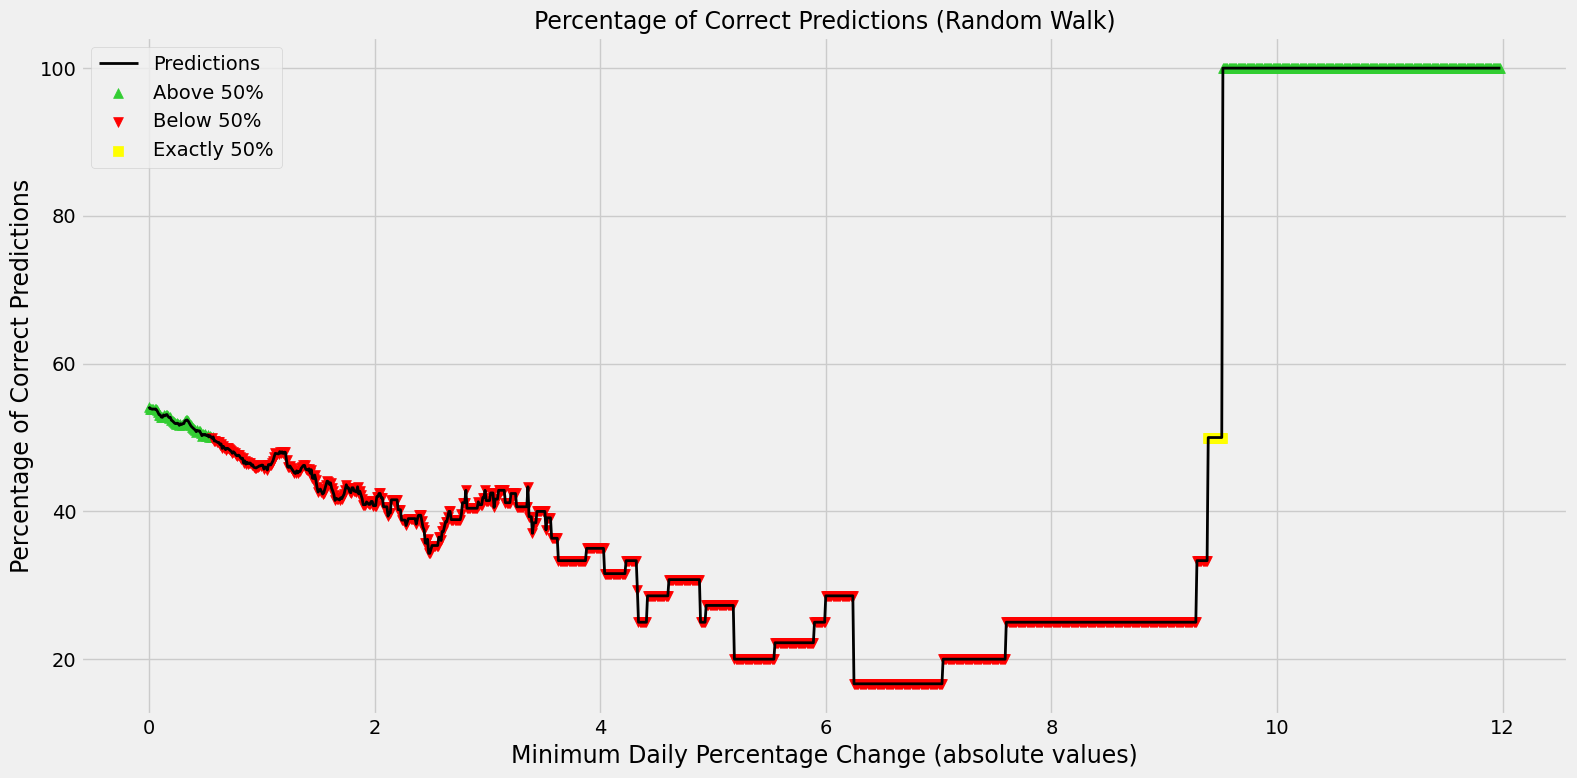

In [28]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Create a line plot connecting the points with linewidth 2
ax.plot(results_df['Pct_Change'], results_df['Percentage_Correct'], linestyle='-', color='black', linewidth=2, label='Predictions')

# Create a scatter plot with custom marker style for values above 50 on the y-axis
above_50_df = results_df[results_df['Percentage_Correct'] > 50]
ax.scatter(above_50_df['Pct_Change'], above_50_df['Percentage_Correct'], color='limegreen', marker='^', s=50, label='Above 50%',)

# Create a scatter plot with red markers for values below 50 on the y-axis
below_50_df = results_df[results_df['Percentage_Correct'] < 50]
ax.scatter(below_50_df['Pct_Change'], below_50_df['Percentage_Correct'], color='red', marker='v', s=50, label='Below 50%',)

# Create a scatter plot with yellow markers for values equal to 50 on the y-axis
equal_to_50_df = results_df[results_df['Percentage_Correct'] == 50]
ax.scatter(equal_to_50_df['Pct_Change'], equal_to_50_df['Percentage_Correct'], color='yellow', marker='s', s=50, label='Exactly 50%',)

# Set labels and title
ax.set_xlabel('Minimum Daily Percentage Change (absolute values)', fontsize=17)
ax.set_ylabel('Percentage of Correct Predictions', fontsize=17)
ax.set_title('Percentage of Correct Predictions (Random Walk)', fontsize=17)

# Add a legend
ax.legend()

# Add a grid
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

## Testing for statistical significance

In [33]:
# Extract the cumulative gains for the holding strategy and the strategy with predictions
cumulative_hold_gain = valid['Cumulative_Hold_Gain'].dropna().values
cumulative_strategy_gain = valid['Cumulative_Strategy_Gain'].dropna().values

# Calculate the mean and standard deviation for both strategies
mean_hold = cumulative_hold_gain.mean() * 100  # Multiply by 100 to express as a percentage
std_hold = cumulative_hold_gain.std() * 100    # Multiply by 100 to express as a percentage
mean_strategy = cumulative_strategy_gain.mean() * 100  # Multiply by 100 to express as a percentage
std_strategy = cumulative_strategy_gain.std() * 100    # Multiply by 100 to express as a percentage

# Perform a t-test
t_stat, p_value = stats.ttest_rel(cumulative_hold_gain, cumulative_strategy_gain)

# Define the significance level (alpha)
alpha = 0.05

# Check if the p-value is less than alpha to determine significance
if p_value < alpha:
    print(f'The t-test is statistically significant (p = {p_value:.2e}).')
    print('The two sets of returns have different means')
else:
    print(f'The t-test is not statistically significant (p = {p_value:.2e}).')
    print('The two sets of returns have the same mean')

# Print the t-value, mean, and standard deviation for both strategies as percentages
print(f'T-Value: {t_stat:.4f}')

The t-test is statistically significant (p = 3.92e-285).
The two sets of returns have different means
T-Value: 51.6596
